In [35]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Camera Calibration 

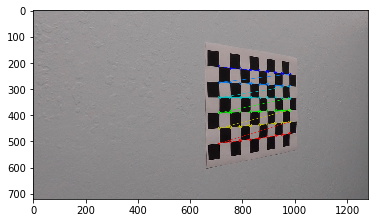

In [36]:
writeup_path = "./writeup/"

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('./camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [28]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

## Example of Undistorted Image

<class 'numpy.ndarray'>


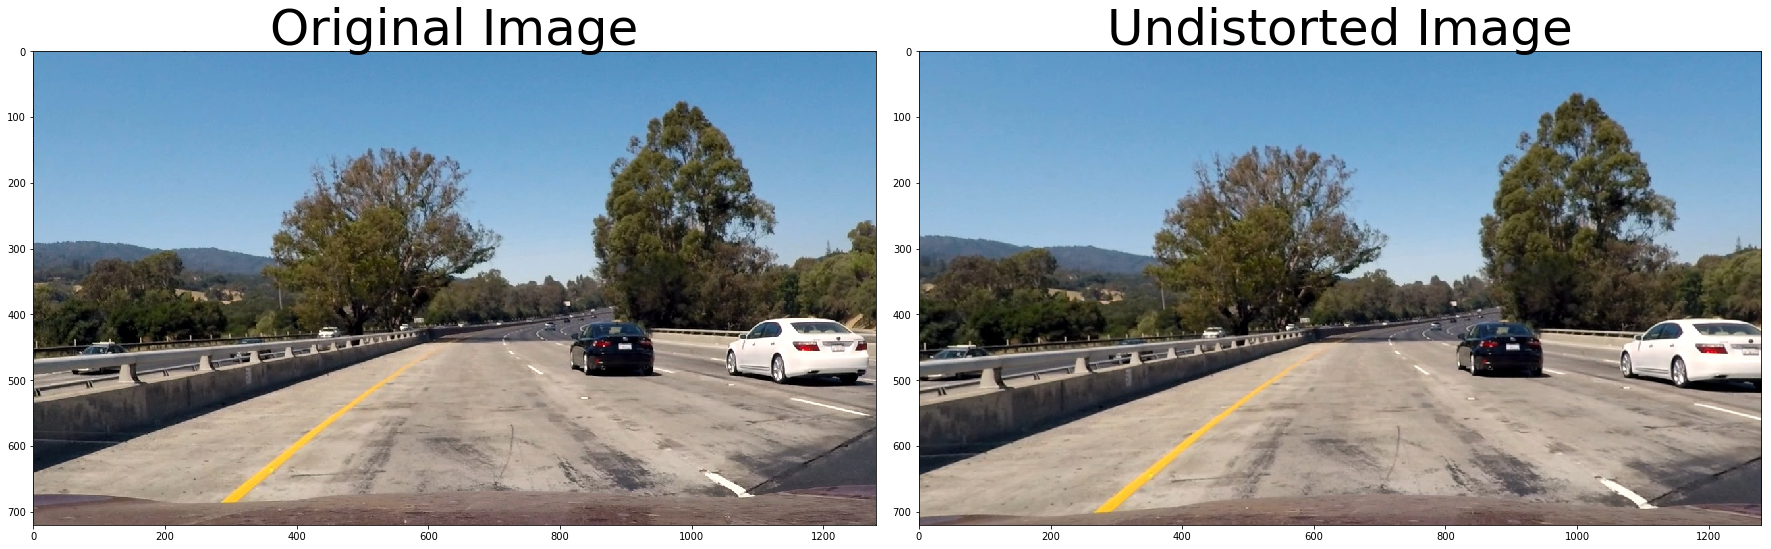

In [29]:
# Distorted Test Image 
distorted_img = mpimg.imread('test_images/test1.jpg')
undistorted_img = cal_undistort(distorted_img, objpoints, imgpoints)
print(type(distorted_img))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline (Test Images)

## Perspective Transform

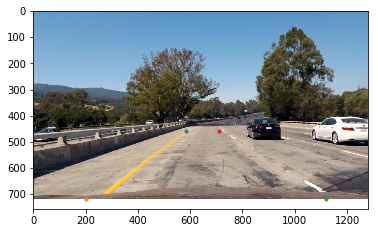

In [30]:
# Debug (View Image to choose source points.)
#%matplotlib qt
#straight_lines_img = mpimg.imread('test_images/straight_lines2.jpg')
#plt.imshow(straight_lines_img)
#plt.show()

plt.imshow(undistorted_img)

# Source 
plt.plot(int(distorted_img.shape[1] / 2 - 55), int(distorted_img.shape[0] / 2 + 100), ".") 
plt.plot(int(distorted_img.shape[1] / 6 - 10), int(distorted_img.shape[0]), ".") 
plt.plot(int(distorted_img.shape[1] * 5 / 6 + 55), int(distorted_img.shape[0]), ".") 
plt.plot(int(distorted_img.shape[1] / 2 + 70), int(distorted_img.shape[0] / 2 + 100), ".") 


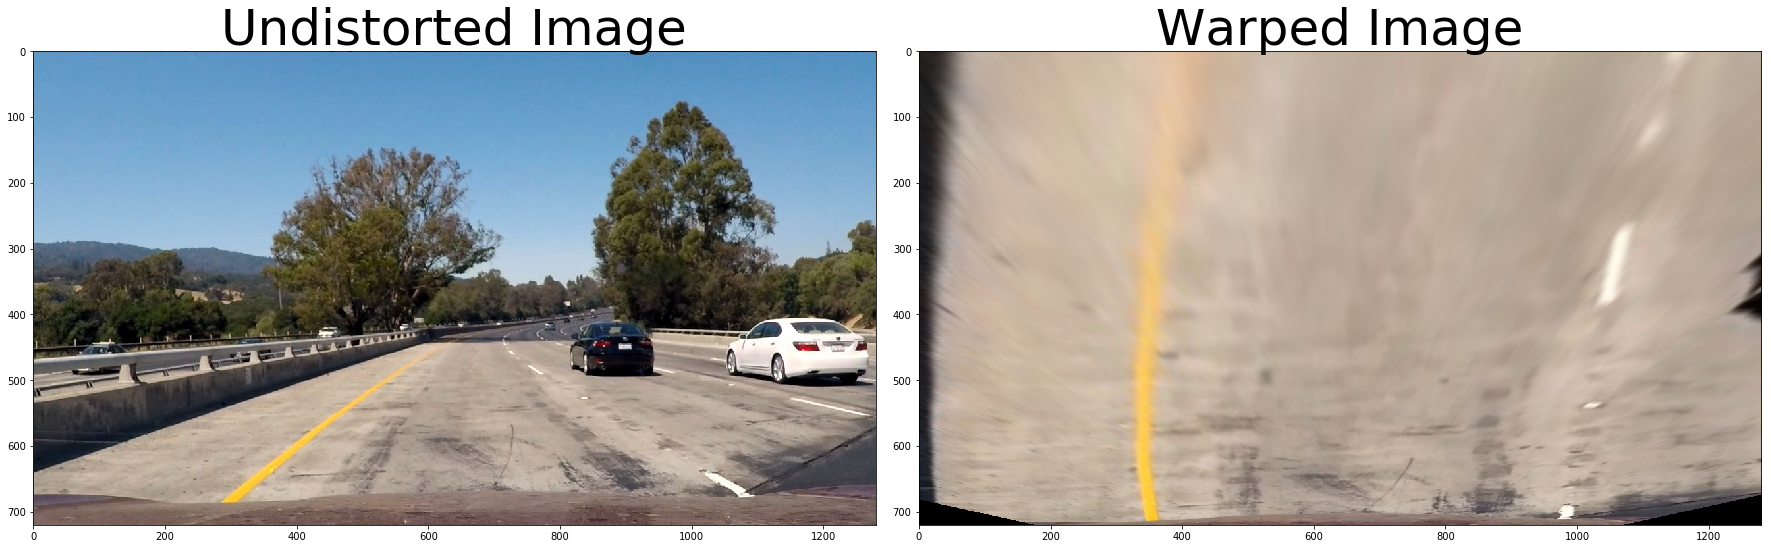

In [31]:
src = np.float32(
    [[(distorted_img.shape[1] / 2) - 55, distorted_img.shape[0] / 2 + 100],
    [((distorted_img.shape[1] / 6) - 10), distorted_img.shape[0]],
    [(distorted_img.shape[1] * 5 / 6) + 60, distorted_img.shape[0]],
    [(distorted_img.shape[1] / 2 + 55), distorted_img.shape[0] / 2 + 100]])
dst = np.float32(
    [[(distorted_img.shape[1] / 4), 0],
    [(distorted_img.shape[1] / 4), distorted_img.shape[0]],
    [(distorted_img.shape[1] * 3 / 4), distorted_img.shape[0]],
    [(distorted_img.shape[1] * 3 / 4), 0]])

def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

def unwarp(img, dst, src):
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    return  cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0])) 
    
warped_img = warp(undistorted_img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted_img)
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(warped_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Threshold Binary Image

In [32]:
def rgb_select(img, channel = 'R', thresh=(0,255)):
    """ Creates a binary image use a given a channel from RGB """
    channel_dict = {
        'R': img[:,:,0],
        'G': img[:,:,1],
        'B': img[:,:,2]
    }
    chosen_channel = channel_dict[channel] 
    binary = np.zeros_like(chosen_channel)
    binary[(chosen_channel > thresh[0]) & (chosen_channel <= thresh[1])] = 1
    return binary

def s_select(img, thresh=(0, 255)):
    """Creates a binary image using the saturation channel of an image."""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def l_select(img, thresh=(0, 255)):
    """Creates a binary image using the lightness channel of an image."""
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary

def sobel_x_select(img, thresh=(0,255)):
    """Creates a binary image using the SobelX operator."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

## Threshold Tests 

In [33]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Interactive Threshold Widget 
def test_combined_binary(low_s, high_s, low_r, high_r, low_sx, high_sx, low_light, high_light):
    
    test_images = glob.glob('test_images/test*.jpg')
    
    for image_name in test_images:
        img = mpimg.imread(image_name)
        undistorted_img = cal_undistort(img, objpoints, imgpoints)
        warped_img = warp(undistorted_img, src, dst)
    
        s_binary = s_select(warped_img, thresh=(low_s, high_s))
        l_binary = l_select(warped_img, thresh=(low_light, high_light))
        sx_binary = sobel_x_select(warped_img, thresh=(low_sx, high_sx))
        r_binary = rgb_select(warped_img, thresh=(low_r,high_r))
    
        combined_binary = np.zeros_like(sx_binary)
        combined_binary[(s_binary == 1) ] = 1
    
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
        f.tight_layout()
        ax1.imshow(warped_img)
        ax1.set_title('Original Image', fontsize=40)
        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined Binary', fontsize=40)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        #plt.savefig(writeup_path + "combined_binary.jpg")
    
low_s = widgets.FloatSlider(min=0, max=255, value=0, description="Sat Min")
high_s = widgets.FloatSlider(min=0, max=255, value=0, description="Sat Max")

low_r = widgets.FloatSlider(min=0, max=255, value=0, description="Red Min")
high_r = widgets.FloatSlider(min=0, max=255, value=0, description="Red Max")

low_sx = widgets.FloatSlider(min=0, max=255, value=0, description="Sobelx Min")
high_sx = widgets.FloatSlider(min=0, max=255, value=0, description="Sobelx Max")

low_light = widgets.FloatSlider(min=0, max=255, value=0, description="light Min")
high_light = widgets.FloatSlider(min=0, max=255, value=0, description="light Max")



interact_manual(test_combined_binary, low_s=low_s, high_s=high_s, low_r=low_r, high_r=high_r, low_sx=low_sx, high_sx=high_sx, low_light=low_light, high_light=high_light)

interactive(children=(FloatSlider(value=0.0, description='Sat Min', max=255.0), FloatSlider(value=0.0, description='Sat Max', max=255.0), FloatSlider(value=0.0, description='Red Min', max=255.0), FloatSlider(value=0.0, description='Red Max', max=255.0), FloatSlider(value=0.0, description='Sobelx Min', max=255.0), FloatSlider(value=0.0, description='Sobelx Max', max=255.0), FloatSlider(value=0.0, description='light Min', max=255.0), FloatSlider(value=0.0, description='light Max', max=255.0), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.test_combined_binary>

Using the widget I created above I experiment with combining the saturation, lightness, red, and sobelx binary threshold images and found that combining all of these channels using the threshold values below produced clearer lane lines. 

Sobel-X Min Threshold -> 70

Sobel-X Max Threshold -> 215

Red Min Treshold -> 235

Red Max Threshold -> 255

Saturation  Min Treshold -> 118

Saturation Max Threshold -> 185

Lightness Min Treshold -> 95

Lightness Max Threshold -> 196

In [34]:
def create_binary_img(warped_img, thresholds=(70, 215, 235, 255, 118, 185, 95, 196)):
    sx_binary = sobel_x_select(warped_img, thresh=(thresholds[0],thresholds[1]))
    r_binary = rgb_select(warped_img, thresh=(thresholds[2],thresholds[3]))
    s_binary = s_select(warped_img, thresh=(thresholds[4], thresholds[5]))
    l_binary = l_select(warped_img, thresh=(thresholds[6], thresholds[7]))
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(l_binary == 1) & (s_binary == 1) | (sx_binary == 1) | (r_binary == 1)] = 1

    return combined_binary

# Lane Line Detection & Fit 

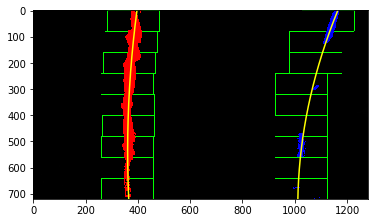

In [10]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, debug=True):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_in_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_in_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    if debug:
        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, ploty


distorted_img = mpimg.imread('test_images/test4.jpg')
undistorted_img = cal_undistort(distorted_img, objpoints, imgpoints)
warped_img = warp(undistorted_img, src, dst)

s_binary = s_select(warped_img, thresh=(180, 255))
sx_binary = sobel_x_select(warped_img, thresh=(109, 220))
r_binary = rgb_select(warped_img, thresh=(227,255))

combined_binary = np.zeros_like(sx_binary)
combined_binary[(s_binary == 1) | (sx_binary == 1) | (r_binary == 1)] = 1

out_img = fit_polynomial(combined_binary)[0]
plt.imshow(out_img)

In [11]:
def search_around_poly(binary_warped, left_fit, right_fit, debug=True):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Calculate fit in meters
    left_fit_in_meters = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_in_meters = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Fit new polynomials
    img_shape = binary_warped.shape
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    result = None
    if debug:
        ## Visualization ##
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    return result, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, ploty

## Search From Prior Frame Test 

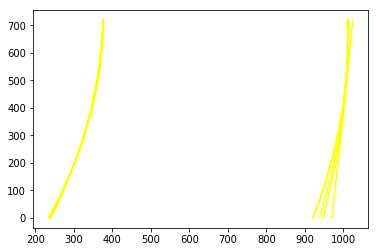

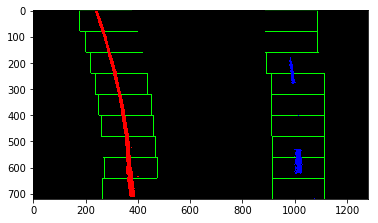

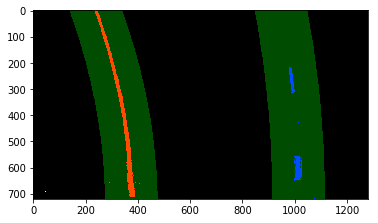

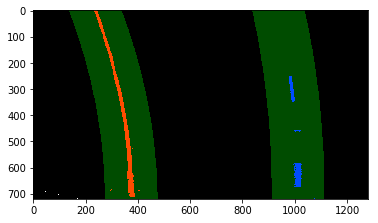

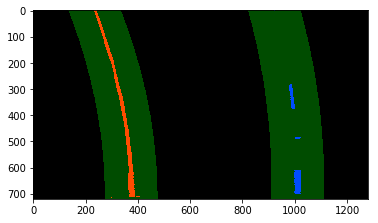

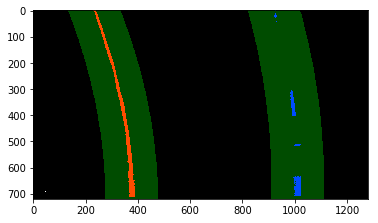

In [12]:
import os 

cap = cv2.VideoCapture('project_video.mp4')
count = 0 

imgs = []
prev_left_fit = None 
prev_right_fit = None 

while count != 5:
    # Capture frame-by-frame
    ret, frame = cap.read()
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    warped_img = warp(undistorted_img, src, dst)

    s_binary = s_select(warped_img, thresh=(180, 255))
    sx_binary = sobel_x_select(warped_img, thresh=(109, 220))
    r_binary = rgb_select(warped_img, thresh=(227,255))
    
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1) | (r_binary == 1)] = 1
    
    if count == 0:
        data = fit_polynomial(combined_binary) 
        out_img = data[0]
        prev_left_fit = data[1]
        prev_right_fit = data[2]
        imgs.append(out_img)
    else:
        data = search_around_poly(combined_binary, prev_left_fit, prev_right_fit)
        imgs.append(data[0])

    count += 1 

cap.release()
cv2.destroyAllWindows()


for img in imgs:
    plt.figure()
    plt.imshow(img)

# Curvature & Center Calculations

In [13]:
def measure_curvature_real(ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

(1144.192741551307, 1123.8373732824073)


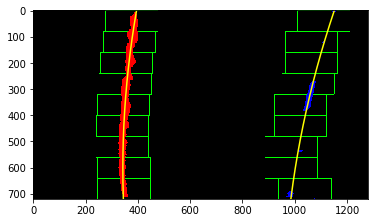

In [14]:
distorted_img = mpimg.imread('test_images/test1.jpg')
undistorted_img = cal_undistort(distorted_img, objpoints, imgpoints)
warped_img = warp(undistorted_img, src, dst)

s_binary = s_select(warped_img, thresh=(180, 255))
sx_binary = sobel_x_select(warped_img, thresh=(109, 220))
r_binary = rgb_select(warped_img, thresh=(227,255))

combined_binary = np.zeros_like(sx_binary)
combined_binary[(s_binary == 1) | (sx_binary == 1) | (r_binary == 1)] = 1

data = fit_polynomial(combined_binary)
plt.imshow(data[0])
print(measure_curvature_real(data[5], data[3], data[4]))


# Pipeline

In [15]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        self.best_fit_in_meters = None
        self.previous_fits = []
        self.previous_fits_in_meters = []
        self.diffs = []
        self.ym_per_pix = 30/720 # meters per pixel in y dimension

    def update_fit(self, fit, fit_in_meters):
        if self.previous_fits == []:
            self.previous_fits.append(fit)
            self.previous_fits_in_meters.append(fit_in_meters)
            self.calculate_average_fit()
            self.detected = True 
            return 
        
        if self.large_difference_exists(fit):
            self.best_fit = self.previous_fits[-1]
            self.best_fit_in_meters = self.previous_fits_in_meters[-1]
            self.previous_fits = []
            self.detected = False 
        else:
            self.previous_fits.append(fit)
            self.previous_fits_in_meters.append(fit_in_meters)
            self.calculate_average_fit()
            
    def large_difference_exists(self,fit):
        if self.previous_fits == []:
            return 
        
        diff = np.abs(self.best_fit - self.previous_fits[-1])
        
        if diff[0] > 0.001:
            return True
        elif diff[1] > 0.50:
            return True 
        elif diff[2] > 500:
            return True 
        return False 

    def calculate_average_fit(self):
        # Remove old fits 
        if len(self.previous_fits) > 3:
            self.previous_fits.pop(0)
            self.previous_fits_in_meters.pop(0)
        
        if len(self.previous_fits) == 1:
            self.best_fit = self.previous_fits[0]
            self.best_fit_in_meters = self.previous_fits_in_meters[0]
            return 

        if len(self.previous_fits) > 1:
            self.best_fit = np.average(self.previous_fits, axis=0)
            self.best_fit_in_meters = np.average(self.previous_fits_in_meters, axis=0)
    
    def measure_radius_of_curvature(self, y_eval):
        curverad = ((1 + (2*self.best_fit_in_meters[0]*y_eval*ym_per_pix + self.best_fit_in_meters[1])**2)**1.5) / np.absolute(2*self.best_fit_in_meters[0])
        return curverad
    
# Final Image
def map_onto_original_img(original_img, binary_warped_img, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed = False, color=(255,255,0), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed = False,color=(24,3,255), thickness=20)
    
    newwarp = unwarp(color_warp, dst, src)

    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    
    return result 
    
def calculate_dist_to_lane_center(img, leftLine, rightLine):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    camera_pos = img.shape[1]/2
    max_y = img.shape[0]
    
    left_x_intercept = leftLine.best_fit[0]*max_y**2 + leftLine.best_fit[1]*max_y + leftLine.best_fit[2]
    right_x_intercept = rightLine.best_fit[0]*max_y**2 + rightLine.best_fit[1]*max_y + rightLine.best_fit[2]
    lane_center = (left_x_intercept + right_x_intercept) / 2
    dist_to_lane_center = (lane_center - camera_pos ) * xm_per_pix
    
    if dist_to_lane_center > 0:
        return "{}m right of center".format(round(abs(dist_to_lane_center), 2))
    else:
        return "{}m  left of center".format(round(abs(dist_to_lane_center), 2))

leftLine = Line()
rightLine = Line()

def lane_detection_pipeline(img):
    # Undistort the image 
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    # Warp the image using a perspective transform 
    warped_img = warp(undistorted_img, src, dst)
    
    # Create Binary Threshold image 
    combined_binary = create_binary_img(warped_img)
    
    left_fitx = None
    right_fitx = None
    ploty = None

    # Fit Polynomial
    if not leftLine.detected and not rightLine.detected:
        _, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, ploty =  fit_polynomial(combined_binary, debug=False)
        leftLine.update_fit(left_fit, left_fit_in_meters)
        rightLine.update_fit(right_fit, right_fit_in_meters)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        _, left_fit, right_fit, left_fit_in_meters, right_fit_in_meters, ploty =  search_around_poly(combined_binary,leftLine.best_fit, rightLine.best_fit,debug=False)
        leftLine.update_fit(left_fit, left_fit_in_meters)
        rightLine.update_fit(right_fit, right_fit_in_meters)
        left_fitx = leftLine.best_fit[0]*ploty**2 + leftLine.best_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    leftCurvRad = leftLine.measure_radius_of_curvature(np.max(ploty))
    rightCurvRad = rightLine.measure_radius_of_curvature(np.max(ploty))
    averageCurvRad = np.average([leftCurvRad, rightCurvRad])
    dist_text = calculate_dist_to_lane_center(img, leftLine, rightLine)
    
    original_img_edited = map_onto_original_img(img, combined_binary, left_fitx, right_fitx, ploty)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_img = cv2.putText(original_img_edited, 'Radius of Curvature {}m'.format(round(averageCurvRad, 2)), (10,50), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    final_result = cv2.putText(radius_img, dist_text, (10,90), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    return final_result
    

In [16]:
def process_image(image):
    return lane_detection_pipeline(image)

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'test_videos/project_submission.mp4'
clip1 = VideoFileClip("project_video.mp4")
final_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time final_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos/project_submission.mp4
[MoviePy] Writing video test_videos/project_submission.mp4


100%|█████████▉| 1260/1261 [04:47<00:00,  4.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/project_submission.mp4 

CPU times: user 8min 5s, sys: 55 s, total: 9min
Wall time: 4min 48s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))